In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
from tqdm import tqdm
import plotly.io as pio
pio.renderers.default = "svg"

import pickle

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
%%script false --no-raise-error
filename = "../../../pylec/studies/data/Synthetic.Household.Profiles.h5"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = pd.read_hdf(filename, "TimeSeries")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    houseinfo = pd.read_hdf(filename, "HouseInfo")
mask = (houseinfo.Country == "France") & (houseinfo.Nmonths == "12")
df = df.loc[:, [str(a) for a in houseinfo[mask].pdIndex.tolist()]]

df["Index"] = pd.date_range(
    start="01-01-2019 00:00:00", end="31-12-2019 23:45:00", freq="15T"
)
df.set_index("Index", drop=True, inplace=True)

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_44.931_4.896_SA_1kWp_crystSi_14_38deg_-3deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-01-01 00:00:00':'2015-01-01 00:10:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2019-01-01 00:00:00',
                            end='2020-01-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('15T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("fr_quoilin_data_valence.pickle")

In [3]:
%%script false --no-raise-error
data = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]

data = data[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((data[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

sub_house_ids = [house_ids[i] for i in [0, 4, 19, 13, 14]]
print(f"Average consumption is {round((data[sub_house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

pv = data[["pv_1kw"]]
pd.to_pickle(pv, "pv.pickle")

load = data[sub_house_ids]
pd.to_pickle(_individuals, "house.pickle")
print("NOT skipped")

In [2]:
pv = pd.read_pickle("pv.pickle")
load = pd.read_pickle("house.pickle")
sub_house_ids = list(load.columns)

# Set up timeline for coalition value

In [3]:
netload = load.copy()

# Fix variables
deltat = timedelta(minutes=15)

# Where do we forecast?
start = datetime(2019, 5, 30, 6, 0, 0)
full_horizon = timedelta(days=3)

# Trainning
training = timedelta(days=31)
start_training = start - training
end_training = start - deltat

# To truncate data
end = start + full_horizon + timedelta(days=7)  # keep a few days after anyway

pv_size = 3
netload = netload.loc[start_training-timedelta(days=1):end, :].copy()
for col in netload.columns:
    netload[col] -= pv_size * pv["pv_1kw"]


freqs = ["15T"]
freq_deltas = [timedelta(minutes=15) - deltat]
horizon = timedelta(days=2) - deltat
end_complete_pred = start + full_horizon

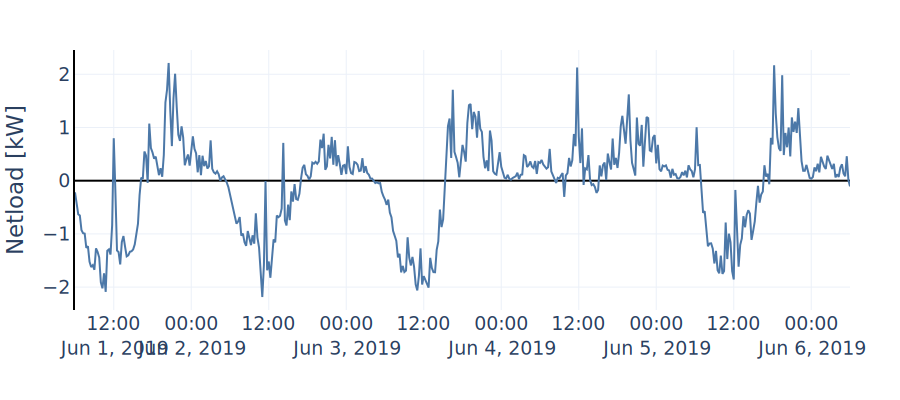

In [10]:
__house_id = list(netload.columns)[0]
graph = netload.loc[start + timedelta(days=2):start + full_horizon + timedelta(days=4), __house_id].copy()

fig = px.line(graph)
fig.data[0].update(line_width=2)
fig.update_layout(
    layout,
    height=400,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="svg")
fig.write_image(f"results/forecast_hard.svg")

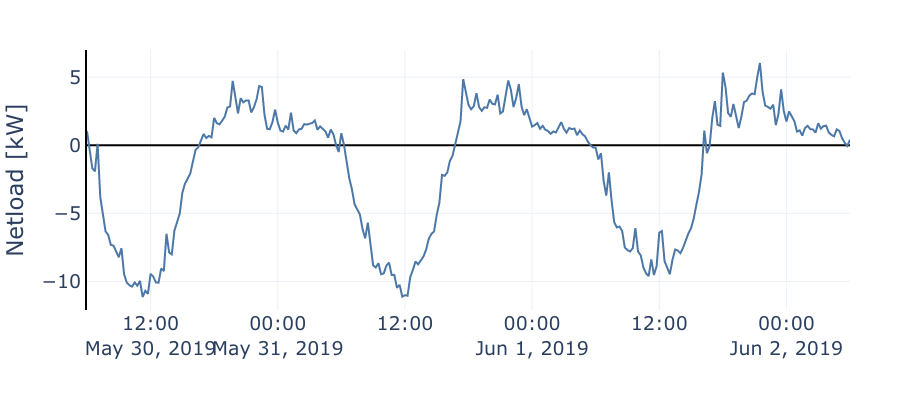

In [6]:
graph = netload.loc[start:start + full_horizon, :].sum(axis=1).copy()

fig = px.line(graph)
fig.data[0].update(line_width=2)
fig.update_layout(
    layout,
    height=400,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="png")

# Collective strategy

In [7]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
#--->?? #m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [8]:
perfect_schedules_concat = []
perfect_energy_concat = []
perfect_communityimport_concat = []
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=False, only_return_schedules=False)
last_iteration = False
for opti_start in tqdm(pd.date_range(end_training + deltat, end_complete_pred, freq="2D"), desc="Optimization #"):
    
    end_optimization = opti_start + horizon + deltat
    if end_optimization > end_complete_pred:
        last_iteration = True
        end_optimization = end_complete_pred
    
    tmp_netload = netload.loc[opti_start:end_optimization, sub_house_ids].copy()
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    if not last_iteration:
        battery_time = opti_start + horizon + deltat
        for i, house_id in enumerate(sub_house_ids):
            spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])
    
    perfect_schedules_concat.append(schedule["schedules"].loc[opti_start:opti_start+horizon].copy())
    perfect_energy_concat.append(schedule["batteryenergy"].loc[opti_start:opti_start+horizon].copy())
    perfect_communityimport_concat.append(schedule["community_import"].loc[opti_start:opti_start+horizon].copy())

perfect_schedules_concat = pd.concat(perfect_schedules_concat, axis=0)
perfect_energy_concat = pd.concat(perfect_energy_concat, axis=0)
perfect_communityimport_concat = pd.concat(perfect_communityimport_concat, axis=0)

Optimization #: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


In [9]:
def cost_wrapper(total_netloads):
    costs = []
    for index in total_netloads.index:
        cost = community_bill(total_netloads.loc[total_netloads.index[0]:index, :], sub_house_ids, 
                              timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
        costs.append(float(cost))
    return costs

def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

_start = end_training + deltat
_end = end_complete_pred
freq = freqs[0]

# Perfect
total_netloads = perfect_schedules_concat.loc[_start:_end, :].copy()
total_netloads.columns = sub_house_ids
for col in total_netloads.columns:
    total_netloads[col] += netload.loc[_start:_end, col]
costs = cost_wrapper(total_netloads)
graph = pd.DataFrame(index=total_netloads.index, data={"perfect": costs})

# PV only
total_netloads = netload.loc[_start:_end, :].copy()
costs = cost_wrapper(total_netloads)
graph["pv only"] = costs

saved_graph = graph.copy()

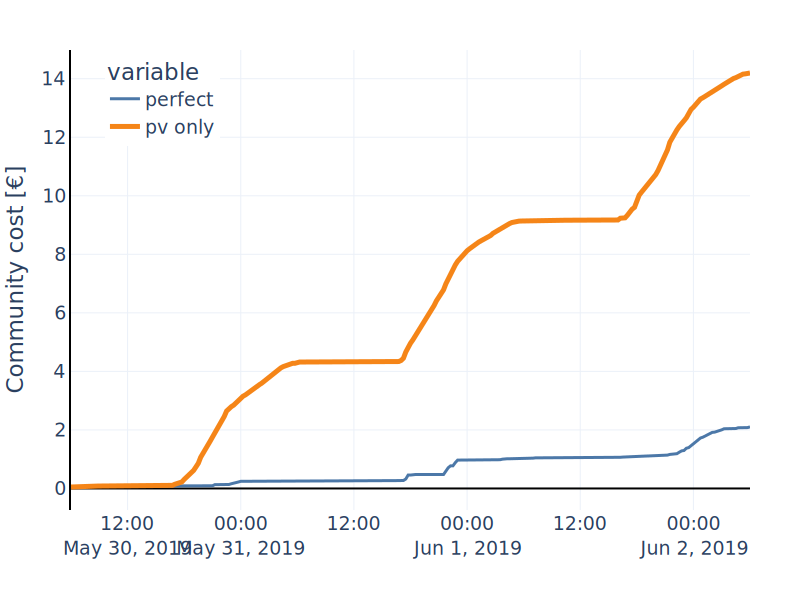

                     perfect  pv only
Index                                
2019-06-02 06:00:00    2.105   14.195


In [10]:
#graph = graph.resample("60T").last()
fig = px.line(graph.loc[:end_complete_pred, :])

fig.data[1].update(line_width=5)
fig.data[0].update(line_width=3)
fig.data[-1].update(line_width=5)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    legend={"x": 0.05},
    xaxis_title="",
    yaxis_title="Community cost [€]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
#fig.write_image(f"results/cumsum_community_import_all_freq.svg")
print(graph.tail(1))

# Individual strategy

In [11]:
def def1_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 1: Merge storage in production.
    """
    result = {}
    _df = df.copy()
    _df["prod_before_storage"] = _df[prod_col]
    _df[prod_col] = _df[prod_col] - _df[storage]
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter 
    result[f"self_prod"] = local * 100 / _df[cons_col].sum()
    result[f"self_cons"] = local * 100 / _df["prod_before_storage"].sum()
    return result

In [12]:
def best_course_action(cons, prod):
    in_kw = prod - cons
    return in_kw

def battery_constraints(in_kw, soc_kwh, spec, deltat=15):
    # Energy
    offset = spec["max_kwh"] * spec["offset"]
    max_charg_kW = max(
        0, (spec["max_kwh"] - offset - soc_kwh) / (spec["eta"] * deltat / 60)
    )
    if in_kw > max_charg_kW:
        in_kw = max_charg_kW

    max_discharg_kW = min(0, (0 + offset - soc_kwh) * spec["eta"] / (deltat / 60))
    if in_kw < max_discharg_kW:
        in_kw = max_discharg_kW

    # Power
    if in_kw > spec["max_kw"]:
        in_kw = spec["max_kw"]

    if in_kw < -spec["min_kw"]:
        in_kw = -spec["min_kw"]
    return in_kw

def update_soc(in_kw, previous_soc_kwh, spec, deltat=15):
    # Power
    assert in_kw <= spec["max_kw"], f"{in_kw} <= {spec['max_kw']}"
    assert in_kw >= -spec["min_kw"], f"{in_kw} >= {-spec['min_kw']}"

    # Energy
    if in_kw > 0:
        _eta = spec["eta"]
    else:
        _eta = 1 / spec["eta"]
    new_soc_kwh = previous_soc_kwh + _eta * in_kw * deltat / 60
    assert new_soc_kwh <= spec["max_kwh"], f"{new_soc_kwh}"
    assert new_soc_kwh >= 0, f"{new_soc_kwh}"
    return new_soc_kwh

def individual_storage_control(df, cons_col, prod_col, storage_col, soc_col, spec):
    in_kws = [0]
    soc_kwhs = [spec["max_kwh"] * spec["offset"]]
    
    for cons, prod in zip(df[cons_col], df[prod_col]):
        in_kw = best_course_action(cons, prod)
        in_kw = battery_constraints(in_kw, soc_kwhs[-1], spec)
        in_kws.append(in_kw)
        soc_kwhs.append(update_soc(in_kw, soc_kwhs[-1], spec))
    
    del in_kws[0]    
    del soc_kwhs[0]
    df[storage_col] = in_kws
    df[soc_col] = soc_kwhs
    return df

In [13]:
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}

graph = load.loc[start:start + full_horizon, sub_house_ids].copy()
graph["pv_1kw"] = pv.loc[start:start + full_horizon, "pv_1kw"]
graph.pv_1kw *= pv_size

for house_id in sub_house_ids:
    graph = individual_storage_control(graph, house_id, "pv_1kw", house_id + "_storage", house_id + "_soc", ref_spec)
result = graph.copy()

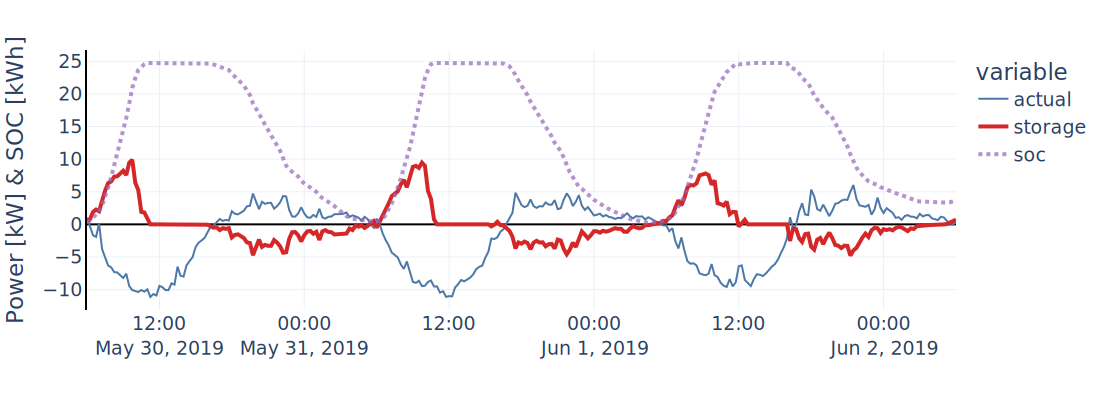

In [14]:
graph = netload.loc[_start:_end, sub_house_ids].copy()  # same as start:start + full_horizon
graph["actual"] = graph.sum(axis=1)
graph = graph[["actual"]]

graph["storage"] = result[[f"{name}_storage" for name in sub_house_ids]].sum(axis=1)
graph["soc"] = result[[f"{name}_soc" for name in sub_house_ids]].sum(axis=1)

fig = px.line(graph, y=["actual", "storage", "soc"])
#fig.data[1].update(line_width=3, opacity=0.8)
fig.data[1].update(line_width=4, 
                   line_color="rgba(214, 39, 40, 1.0)")
fig.data[2].update(line_width=4, 
                   line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
fig.update_layout(
    layout,
    height=400,
    width=1100,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Power [kW] & SOC [kWh]",
    yaxis_dtick=5,
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

Version une méga batterie pour la communauté.

In [15]:
%%script false --no-raise-error
nb_houses = len(sub_house_ids)

battery_size = 5 * nb_houses
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}

graph = load.loc[start:start + full_horizon, sub_house_ids].copy()
graph["community_kW"] = graph.sum(axis=1)
graph["pv_1kw"] = pv.loc[start:start + full_horizon, "pv_1kw"]
graph.pv_1kw *= nb_houses * pv_size
graph.drop(columns=sub_house_ids, inplace=True)

graph = individual_storage_control(graph, "community_kW", "pv_1kw", "storage", "soc", ref_spec)

In [16]:
%%script false --no-raise-error
fig = px.line(graph.loc[:, :],
              y=["community_kW", "pv_1kw", "storage", "soc"])
fig.data[2].update(line_width=4)
fig.data[3].update(line_width=4, line_dash="dot")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="png")

## Results

In [17]:
graph = saved_graph.copy()

# Reactive
total_netloads = result[[f"{name}_storage" for name in sub_house_ids]].copy()
total_netloads.columns = sub_house_ids
for col in total_netloads.columns:
    total_netloads[col] += netload.loc[_start:_end, col]
costs = cost_wrapper(total_netloads)
graph["individuel"] = costs

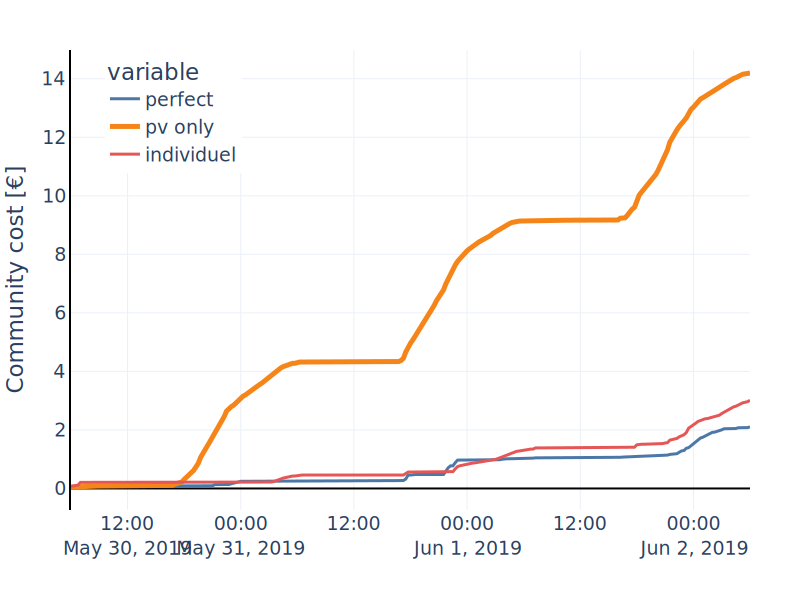

                     perfect  pv only  individuel
Index                                            
2019-06-02 06:00:00    2.105   14.195       3.015


In [18]:
#graph = graph.resample("60T").last()
fig = px.line(graph.loc[:end_complete_pred, :])

fig.data[1].update(line_width=5)
fig.data[0].update(line_width=3)
fig.data[-1].update(line_width=3)
fig.data[-2].update(line_width=5)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    legend={"x": 0.05},
    xaxis_title="",
    yaxis_title="Community cost [€]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/coalition_value.svg")
print(graph.tail(1))